In [0]:
import tensorflow as tf
import pandas as pd

In [4]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [0]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [0]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    with tf.device('/gpu:0'):
        m = X.shape[0]                  # number of training examples
        mini_batches = []
        np.random.seed(seed)

        # Step 1: Shuffle (X, Y)
        permutation = list(np.random.permutation(m))
        shuffled_X = X[permutation,:,:,:]
        shuffled_Y = Y[permutation,:]

        # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
        num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
        for k in range(0, num_complete_minibatches):
            mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
            mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)

        # Handling the end case (last mini-batch < mini_batch_size)
        if m % mini_batch_size != 0:
            mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
            mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)

        return mini_batches

In [0]:
X_train_orig=pd.read_csv('train.csv') 
X_test_orig= pd.read_csv('test.csv')

In [11]:
print(X_train_orig.shape)
print(X_test_orig.shape)


(42000, 785)
(28000, 784)


In [0]:
X_train = (X_train_orig.ix[:,1:].values).astype('float32')/255
X_test = X_test_orig.values.astype('float32')/255
Y_train_orig=X_train_orig.ix[:,0].values.astype('int32')
Y_train= convert_to_one_hot(Y_train_orig, 10)



In [13]:
print(Y_train_orig.shape)

(42000,)


In [14]:
print (Y_train.shape)

(42000, 10)


In [15]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
print(X_train.shape)


(42000, 28, 28, 1)


In [0]:
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [0]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, [None, n_y])
    return X, Y


In [0]:
def forward_propagation(X):
    with tf.device('/gpu:0'):
        conv1 = tf.layers.conv2d(
          inputs=X,
          filters=32,
          kernel_size=[5, 5],
          padding="same",
          activation=tf.nn.relu)
        pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

        conv2 = tf.layers.conv2d(
          inputs=pool1,
          filters=64,
          kernel_size=[5, 5],
          padding="same",
          activation=tf.nn.relu)

        pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

        P2 = tf.contrib.layers.flatten(pool2)

        Z3 = tf.contrib.layers.fully_connected(P2, 10,activation_fn=None)

        return Z3



In [0]:
def compute_cost(Z, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Z, labels=Y))
    return cost

In [0]:
def model(X_train, Y_train, X_test, learning_rate=0.009,
          num_epochs=10, minibatch_size=64, print_cost=True):
    with tf.device('/gpu:0'):
        (m, n_H0, n_W0, n_C0) = X_train.shape             
        n_y = Y_train.shape[1]  
        #print(Y_train.shape)
        costs = []                           
        X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
        Z= forward_propagation(X)
        cost= compute_cost(Z,Y)
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            sess.run(init)
            for epoch in range(num_epochs):
                minibatch_cost = 0.
                num_minibatches = int(m / minibatch_size)
                minibatches = random_mini_batches(X_train, Y_train, minibatch_size,0)
                for minibatch in minibatches:
                    (minibatch_X, minibatch_Y) = minibatch
                    #print(minibatch_Y.shape)
                    _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                    minibatch_cost += temp_cost / num_minibatches
                if print_cost == True and epoch % 5 == 0:
                    print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
                if print_cost == True and epoch % 1 == 0:
                    costs.append(minibatch_cost)  
            plt.plot(np.squeeze(costs))
            plt.ylabel('cost')
            plt.xlabel('iterations (per tens)')
            plt.title("Learning rate =" + str(learning_rate))
            plt.show()

            predict_op = tf.argmax(Z, 1)
            correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

            accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
            print(accuracy)
            train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
            predict_test =  predict_op.eval({X: X_test})
            
            print("Train Accuracy:", train_accuracy)
            #print("Test Accuracy:", test_accuracy)

            return predict_test, train_accuracy

Cost after epoch 0: 0.122183
Cost after epoch 5: 0.037462


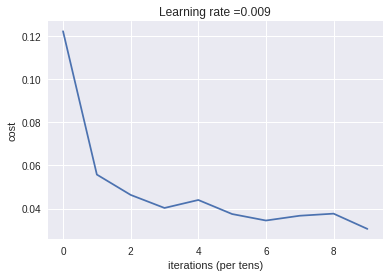

Tensor("Mean_8:0", shape=(), dtype=float32, device=/device:GPU:0)
Train Accuracy: 0.99366665


In [32]:
predict,_ = model(X_train, Y_train, X_test)

In [0]:
submissions=pd.DataFrame({"ImageId": list(range(1,len(predict)+1)),
                         "Label": predict})

In [42]:
submissions.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [0]:
submissions.to_csv('submissions.csv', index=False)
from google.colab import files


files.download('submissions.csv')